# Advanced machine learning - Task 3

While the previous projects dealt with medical image features, we turn now to the classification of entire time series into one of 4 classes. This time you will work with the original ECG recordings of different length sampled as 300Hz to predict heart rhythm.

In [28]:
import numpy as np
import pandas as pd
import pywt
import sklearn
import matplotlib.pyplot as plt
import biosppy
from sklearn.preprocessing import normalize
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

In [29]:
X_train_df = pd.read_csv("X_train.csv", index_col='id')
y_train_df = pd.read_csv("y_train.csv", index_col='id')
X_test_df = pd.read_csv("X_test.csv", index_col='id')

In [30]:
X_train_df.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17969,x17970,x17971,x17972,x17973,x17974,x17975,x17976,x17977,x17978
count,5117.000000,5117.000000,5117.000000,5117.000000,5117.000000,5117.000000,5117.000000,5117.000000,5117.000000,5117.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.560876,1.640023,1.978894,2.541333,3.301544,3.995701,4.722103,5.354895,5.872777,6.233340,...,12.0,13.0,14.0,15.0,15.0,16.0,17.0,17.0,17.0,17.0
std,416.975264,416.177167,415.712095,415.664544,416.347072,417.637904,419.285441,420.753973,421.608526,421.858841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-4687.000000,-4639.000000,-4564.000000,-4483.000000,-4397.000000,-4307.000000,-4204.000000,-4082.000000,-3957.000000,-3847.000000,...,12.0,13.0,14.0,15.0,15.0,16.0,17.0,17.0,17.0,17.0
25%,-104.000000,-104.000000,-104.000000,-105.000000,-105.000000,-106.000000,-106.000000,-106.000000,-107.000000,-107.000000,...,12.0,13.0,14.0,15.0,15.0,16.0,17.0,17.0,17.0,17.0
50%,-7.000000,-7.000000,-8.000000,-8.000000,-8.000000,-7.000000,-8.000000,-8.000000,-8.000000,-8.000000,...,12.0,13.0,14.0,15.0,15.0,16.0,17.0,17.0,17.0,17.0
75%,114.000000,114.000000,112.000000,114.000000,115.000000,114.000000,114.000000,116.000000,116.000000,113.000000,...,12.0,13.0,14.0,15.0,15.0,16.0,17.0,17.0,17.0,17.0
max,4721.000000,4570.000000,4440.000000,4372.000000,4350.000000,4367.000000,4399.000000,4380.000000,4218.000000,4077.000000,...,12.0,13.0,14.0,15.0,15.0,16.0,17.0,17.0,17.0,17.0


In [31]:
X_test_df.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17969,x17970,x17971,x17972,x17973,x17974,x17975,x17976,x17977,x17978
count,3411.000000,3411.000000,3411.000000,3411.000000,3411.000000,3411.000000,3411.000000,3411.000000,3411.000000,3411.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,-11.104661,-11.139842,-10.976546,-10.710935,-10.513632,-10.245676,-9.737907,-9.087951,-8.638229,-8.472882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,475.138662,473.002653,470.473594,468.743069,467.779369,466.939159,466.744024,466.848577,466.251590,465.563499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-6474.000000,-6483.000000,-6431.000000,-6307.000000,-6141.000000,-5945.000000,-5727.000000,-5483.000000,-5213.000000,-4920.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,-111.000000,-110.500000,-110.000000,-111.000000,-108.500000,-106.000000,-106.000000,-107.000000,-107.000000,-107.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,-10.000000,-9.000000,-9.000000,-9.000000,-10.000000,-11.000000,-11.000000,-11.000000,-12.000000,-12.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,102.000000,103.000000,104.000000,104.000000,102.000000,99.500000,97.000000,96.500000,98.500000,98.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,3931.000000,4158.000000,4495.000000,4773.000000,5096.000000,5336.000000,5514.000000,5678.000000,5820.000000,5888.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Define necessary functions

In [ ]:
def remove_starting_period(data):
    start = 700
    data = data.drop(data.columns[range(start)], axis=1)
    return data

def check_flipped_ecg(data):
    a = (np.max(data, axis=1) <= -0.75*np.min(data, axis=1))
    idx = np.where(a)[0]
    data.loc[idx,:] = - data.loc[idx,:]
    return data

def extract_peaks_intervals(tmpl):
    norm_tmpl = normalize(tmpl)
    wave = np.array(sum(norm_tmpl) / len(norm_tmpl))
    idx = np.where(wave == np.max(wave))
    R_location = idx[0][0]
    before_R = wave[:R_location]
    Q_location = np.where(wave == np.min(before_R[R_location-35:R_location]))
    Q_location = Q_location[0][0]
    P_location = np.where(before_R[0:Q_location] == np.max(before_R[0:Q_location]))
    P_location = P_location[0][0]
    after_R = wave[R_location:]
    S_location = np.where(wave == np.min(after_R[:25]))[0][0]
    T_location = np.where(wave == np.max(after_R[S_location-R_location+1:]))[0][0]

    PR_interval = R_location - P_location
    QRS_interval = S_location - Q_location
    ST_interval = T_location - S_location
    
    return R_location, Q_location, P_location, S_location, T_location, PR_interval, QRS_interval, ST_interval, np.ptp(wave), np.average(wave)

def features(data):
    num_row = data.shape[0]
    num_col = 118  # num of features defined below
      
    output = np.empty((num_row, num_col))
    
    for i in range(num_row):
        # extract ecg information
        idx = np.isfinite(data.loc[i,:])
        ecg_output = biosppy.signals.ecg.ecg(data.loc[i,idx],sampling_rate=300, show=False)
        
        # rpeaks => 5 features
        rpeaks = ecg_output['rpeaks']
        # relative to number of observations
        output[i,0] = rpeaks.shape[0] / np.sum(idx==True)
        #average and std of delta betweeen rpeaks
        output[i,1] = np.mean(np.diff(rpeaks))   
        output[i,2] = np.std(np.diff(rpeaks))        
        output[i,3] = np.quantile(np.diff(rpeaks),0.05) 
        output[i,4] = np.quantile(np.diff(rpeaks),0.95)
        
        # heart rate => 7 features
        hr = ecg_output['heart_rate']
        if hr.shape[0] != 0:
            output[i,5] = np.min(hr)
            output[i,6] = np.max(hr)
            output[i,7] = np.quantile(hr, 0.05)
            output[i,8] = np.quantile(hr, 0.95)
            output[i,9] = np.std(hr)
            output[i,10] = np.std(hr)
        else:
            output[i,5:11] = float("nan")
            
        # templates => 
        tmpl = ecg_output['templates']
        # median, mean and std across templates (rows) for each time point (col)
        data_mean = np.mean(tmpl, axis=0)
        data_median = np.median(tmpl, axis=0)
        data_std = np.std(tmpl, axis=0)
        data_max = np.max(tmpl, axis=0)
        data_min = np.min(tmpl, axis=0)
        output[i,11] = np.mean(np.abs(data_mean - data_median))
        output[i,12] = np.mean(np.abs(data_max))
        output[i,13] = np.mean(np.abs(data_min))
        output[i,14] = np.mean(data_std)
        output[i,15] = output[i, 14] / output[i, 12]  # like a normalized volatility (peak=1)
        
        # wavelet transform
        cA, cD = pywt.dwt(ecg_output['templates'], 'db2')
        # calc stats per bucket (covering 20pts)
        k=16
        for j in range(9):
            idx = range(j*10,(j+1)*10)
            data_mean = np.mean(cD[:,idx], axis=0)
            data_median = np.median(cD[:,idx], axis=0)
            data_std = np.std(cD[:,idx], axis=0)
            data_max = np.max(cD[:,idx], axis=0)
            data_min = np.min(cD[:,idx], axis=0)
            output[i,k] = np.mean(data_median)
            output[i,k+1] = np.mean(data_max)
            output[i,k+2] = np.mean(data_min)
            output[i,k+3] = np.mean(data_mean)   
            output[i,k+4] = np.mean(data_std)       
            # same with data normalized by peak value
            data_mean = np.mean(cA[:,idx], axis=0)
            data_median = np.median(cA[:,idx], axis=0)
            data_std = np.std(cA[:,idx], axis=0)
            data_max = np.max(cA[:,idx], axis=0)
            data_min = np.min(cA[:,idx], axis=0)
            output[i,k+5] = np.mean(data_median)
            output[i,k+6] = np.mean(data_max)
            output[i,k+7] = np.mean(data_min)
            output[i,k+8] = np.mean(data_mean)   
            output[i,k+9] = np.mean(data_std)               
            k = k+10
            
        
        # add R, Q, P, S, T and their intervals
        peaks_intervals = extract_peaks_intervals(tmpl)
        for feature in peaks_intervals:
            output[i, k] = feature
            k += 1
            
        # ptp = np.ptp(data.loc[i,idx])
        # avg = np.avg(data.loc[i,idx])
        # output[i, k] = ptp
        # output[i, k+1] = avg
        
            
        if i % 500 == 0:
            print(i)
            
    col_mean = np.nanmean(output, axis=0)
    idx = np.where(np.isnan(output))
    print('Nr of NaNs: ', idx[1].shape[0])
    print(idx)
    output[idx] = np.take(col_mean, idx[1])
    
    return output

def process_data(data):
    data = remove_starting_period(data)
    data = check_flipped_ecg(data)
    return features(data)
    



## Extracting peaks and intervals

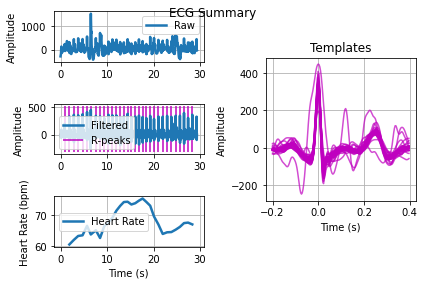

In [32]:
i = 100
idx = np.isfinite(X_train_df.loc[i,:])
a = biosppy.signals.ecg.ecg(X_train_df.loc[i,idx], sampling_rate=300)


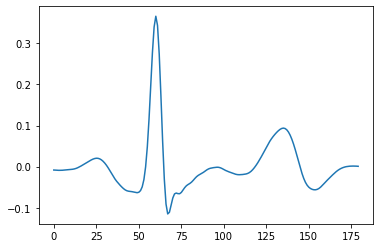

In [33]:
norm_tmpl = normalize(a["templates"])
wave = np.array(sum(norm_tmpl) / len(norm_tmpl))
plt.plot(wave)

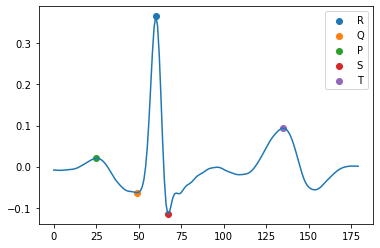

In [34]:
idx = np.where(wave == np.max(wave))
R_location = idx[0][0]
before_R = wave[:R_location]
Q_location = np.where(wave == np.min(before_R[R_location-35:R_location]))
Q_location = Q_location[0][0]
P_location = np.where(before_R[0:Q_location] == np.max(before_R[0:Q_location]))
P_location = P_location[0][0]
after_R = wave[R_location:]
S_location = np.where(wave == np.min(after_R[:25]))[0][0]
T_location = np.where(wave == np.max(after_R[S_location+1:]))[0][0]

PR_interval = R_location - P_location
QRS_interval = S_location - Q_location
ST_interval = T_location - S_location

plt.plot(wave)
plt.scatter(R_location, wave[R_location], label='R')
plt.scatter(Q_location, wave[Q_location], label='Q')
plt.scatter(P_location, wave[P_location], label='P')
plt.scatter(S_location, wave[S_location], label='S')
plt.scatter(T_location, wave[T_location], label='T')
plt.legend()
plt.show()


## Training

In [ ]:
train_data = process_data(X_train_df)

In [ ]:
num_folds = 10
kf = sklearn.model_selection.KFold(num_folds)
lr = [0.01, 0.05, 0.1, 0.25, 0.5]
n_estimators = [100, 250, 500, 750, 1000]
max_depth = [5, 6, 7, 8, 9]
avg_F1 = np.zeros(len(lr))
conf_mat = np.zeros((4,4))
for lr_i in lr:
    for train_index, test_index in kf.split(train_data):
        x_trn, y_trn = train_data[train_index], y[train_index]
        x_tst, y_tst = train_data[test_index], y[test_index]
        clf = sklearn.ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=600, max_depth=8, 
                                    min_samples_split=50, min_samples_leaf=30,
                                    max_features='sqrt', random_state=1, subsample=0.8)
        clf.fit(x_trn, y_trn)
        y_pred = clf.predict(x_tst)
        avg_F1[idx] = avg_F1[idx] + f1_score(y_tst, y_pred, average='micro') / num_folds
        conf_mat = conf_mat + confusion_matrix(y_tst, y_pred)/ num_folds
    
    

## Prediction

In [ ]:
clf = sklearn.ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=600, max_depth=8, 
                                    min_samples_split=50, min_samples_leaf=30,
                                    max_features='sqrt', random_state=1, subsample=0.8)
clf.fit(train_data, y_train_df)

In [ ]:
test_data = process_data(X_test_df)

In [ ]:
predictions = clf.predict(test_data)

In [ ]:
ids = np.arange(0, len(predictions))
output = pd.DataFrame({'id': ids,
                           'y': predictions})
output.to_csv("output.csv", index=False)